<a href="https://colab.research.google.com/github/YDj-robot/Air-Quality-Archive-Nakuru-City-in-Kenya/blob/main/Air_Quality_Nakuru_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Air Quality Archive Nakuru City in Kenya
This data set contains PM (particulate matter), temperature, and humidity readings taken with low-cost sensors. These sensors measure the concentration of PM in the air, including particles with diameters less than or equal to 1 micrometer (PM1), 2.5 micrometers (PM2.5), and particles with diameters less than or equal to 10 micrometers (PM10). The data set includes information on the sensor type, date, time, and location of the readings, as well as the sensor’s specific measurement values for Temperature (C), Humidity (%), PM1, PM2.5, and PM10. The data set is ideal for researchers and individuals interested in studying air quality and low-cost sensors in PM measurement. The dataset is stored in CSV format and can be opened using editors like Microsoft Excel, Google Sheets, LibreOffice Calc, etc. Note that P0 in the data represents PM1, P2 represents PM2.5, and P1 represents PM10.
###August 2021 Sensor Data Archive
https://openafrica.net/dataset/678d3d27-1973-4c50-b1c0-5df331fd6d4e/resource/210c1d47-7c77-4bc9-a89b-51c0abb285dc/download/august_2021_sensor_data_archive.csv

In [ ]:
import pytz
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
file_path = "/content/august_2021_sensor_data_archive.csv"
df_all = pd.read_csv(file_path, delimiter=';')
df_all.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,145,DHT22,3528,-0.286,36.067,2021-08-03T07:20:18.209955+00:00,humidity,55
1,145,DHT22,3528,-0.286,36.067,2021-08-03T07:20:18.209955+00:00,temperature,22
2,144,SDS011,3528,-0.286,36.067,2021-08-03T07:20:18.211556+00:00,P2,4
3,144,SDS011,3528,-0.286,36.067,2021-08-03T07:20:18.211556+00:00,P1,5
4,144,SDS011,3528,-0.286,36.067,2021-08-03T07:22:58.571931+00:00,P2,4


In [ ]:
def wrangle(df):

    # Get the P2 values data
    df = df[df['value_type'] == 'P2']

    # Select only the timestamp and P2 values
    df = df[['timestamp', 'value']]
    df.rename(columns={'value': 'P2'}, inplace=True)
    df.set_index('timestamp', inplace=True)

    # Localize timezone
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_convert("Africa/Nairobi")

    # Resample to 1H window
    df = df["P2"].resample("1H").mean().to_frame()

    # Add lag feature
    df["P2.L1"] = df["P2"].shift(1)

    # Drop Nan rows
    df.dropna(inplace=True)

    return df

In [ ]:
df_P2 = wrangle(df_all)
df_P2.index[:5]

DatetimeIndex(['2021-08-03 11:00:00+03:00', '2021-08-03 12:00:00+03:00',
               '2021-08-03 13:00:00+03:00', '2021-08-03 14:00:00+03:00',
               '2021-08-03 15:00:00+03:00'],
              dtype='datetime64[ns, Africa/Nairobi]', name='timestamp', freq='H')

<Axes: title={'center': 'Distribution of PM2.5 Readings'}>

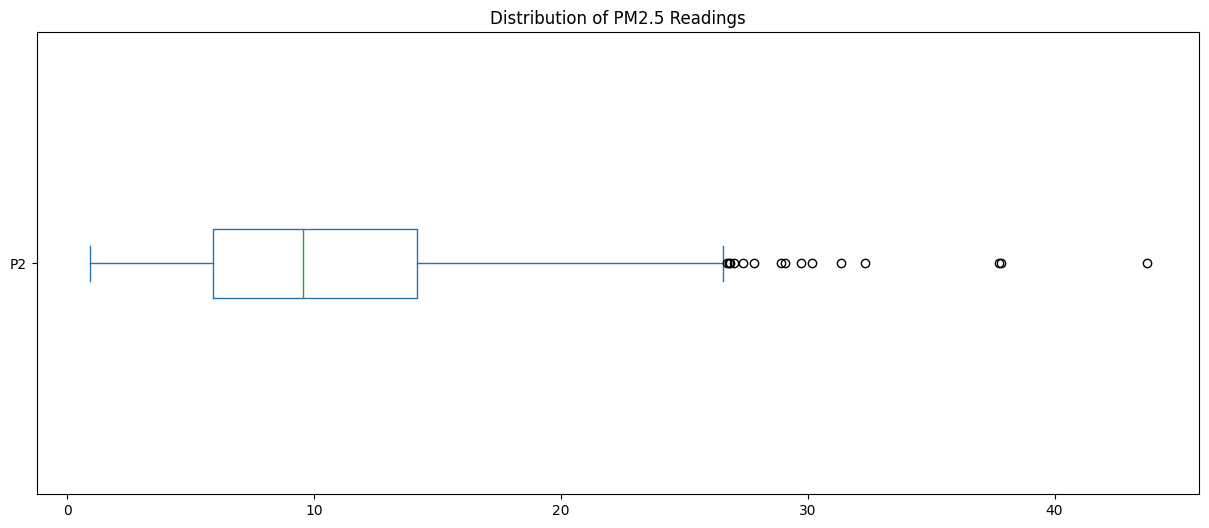

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
df_P2["P2"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax)

<Axes: title={'center': 'PM2.5 Time Series'}, xlabel='Time', ylabel='PM2.5'>

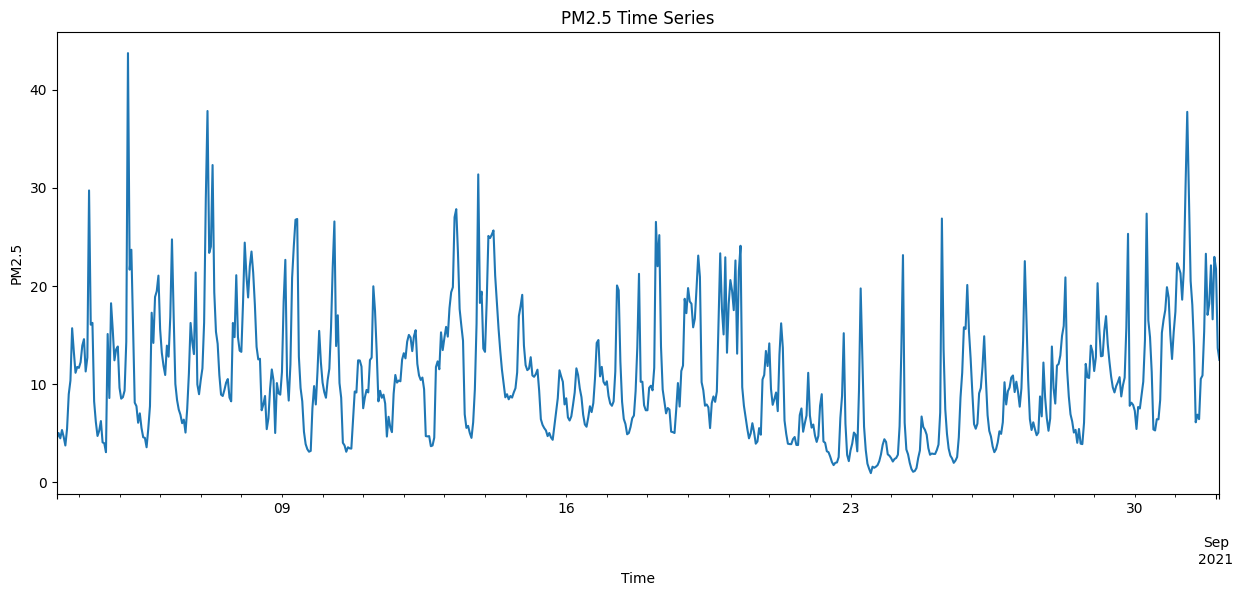

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
df_P2["P2"].plot(xlabel="Time", ylabel="PM2.5", title="PM2.5 Time Series", ax=ax)

###Ploting the rolling average of the "P2" readings in df. Use a window size of 168 (the number of hours in a week).

<Axes: title={'center': 'Weekly Rolling Average'}, xlabel='timestamp', ylabel='PM2.5'>

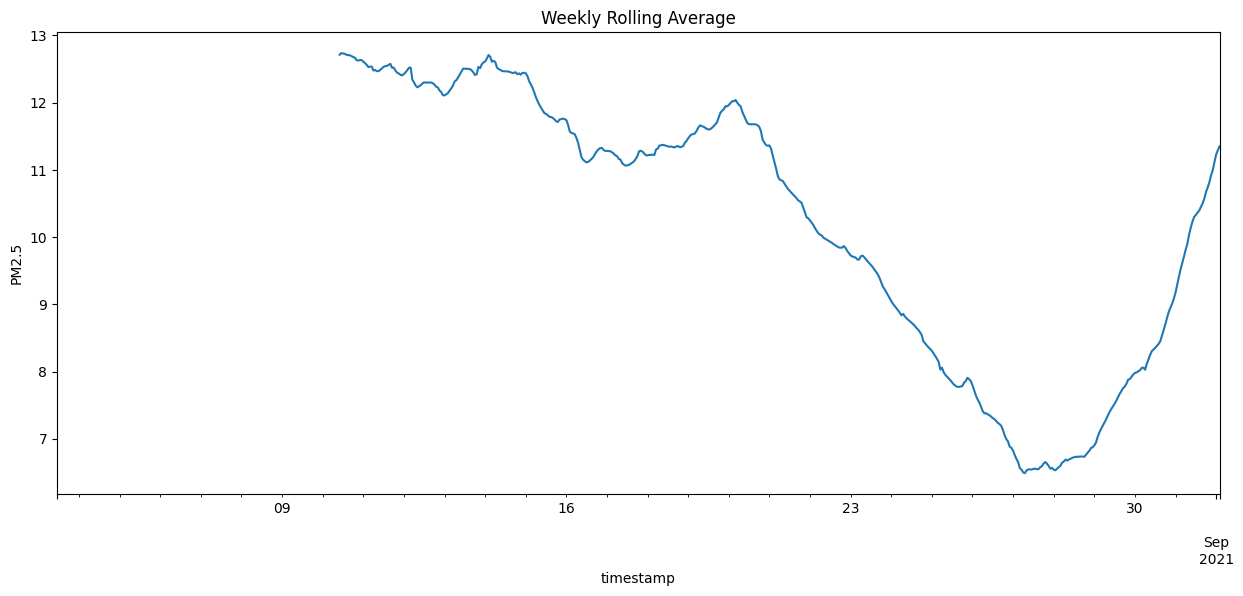

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
df_P2["P2"].rolling(168).mean().plot(ax=ax, ylabel="PM2.5", title="Weekly Rolling Average")

##Linear Regression with Time Series Data

In [ ]:
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

In [ ]:
df_P2.corr()

,P2,P2.L1
P2,1.000000,0.778388
P2.L1,0.778388,1.000000


Text(0.5, 1.0, 'PM2.5 Auto correlation PLot')

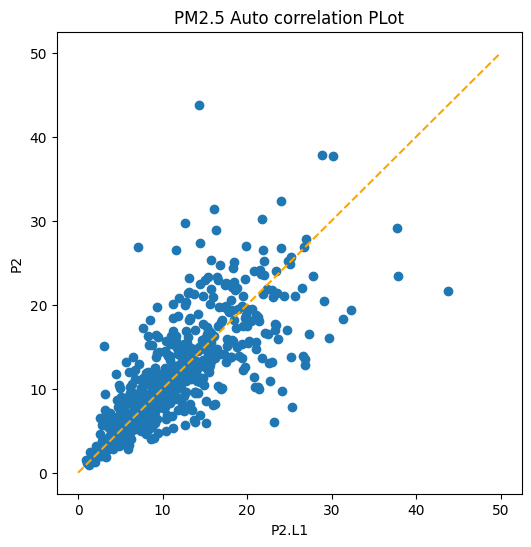

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df_P2["P2.L1"], y=df_P2["P2"])
ax.plot([0,50], [0,50], linestyle="--", color="orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5 Auto correlation PLot")

###Split the data to train-test time series data

In [ ]:
target = "P2"
y = df_P2[target]
X = df_P2.drop(columns=target)

In [ ]:
cutoff = int(len(X) * 0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

## Build Model

In [ ]:
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 10.52
Baseline MAE: 4.99


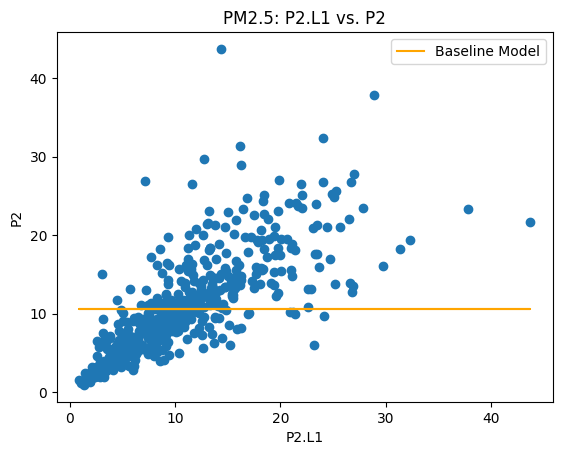

In [ ]:
plt.plot(X_train["P2.L1"], y_pred_baseline, color="orange", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5: P2.L1 vs. P2")
plt.legend();

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
check_is_fitted(model)

In [ ]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 2.71
Test MAE: 2.74


In [ ]:
print("Is Training MAE less than the Baseline MAE:", training_mae < mae_baseline)
print("Is Test MAE less than the Baseline MAE:", test_mae < mae_baseline)

Is Training MAE less than the Baseline MAE: True
Is Test MAE less than the Baseline MAE: True


### Communicate Results

In [ ]:
intercept =  model.intercept_.round(2)
coefficient =  model.coef_.round(2)[0]

print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

P2 = 2.39 + (0.77 * P2.L1)


In [ ]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred": model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2021-08-26 09:00:00+03:00,6.818182,10.497035
2021-08-26 10:00:00+03:00,5.217391,7.665595
2021-08-26 11:00:00+03:00,4.636364,6.427223
2021-08-26 12:00:00+03:00,3.625000,5.977739
2021-08-26 13:00:00+03:00,3.045455,5.195347


In [ ]:
fig = px.line(df_pred_test, labels={"value":"P2"})
fig.show()